<a href="https://colab.research.google.com/github/thecoderwithHat/AIRL-IISC/blob/main/q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-ignite

import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.utils import convert_tensor
import ignite.metrics
import ignite.contrib.handlers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
DATA_DIR='./data'

IMAGE_SIZE = 32

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 32
EPOCHS = 200

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


In [ ]:
train_transform = transforms.Compose([
    transforms.TrivialAugmentWide(interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.RandomErasing(p=0.1)
])

In [ ]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 170M/170M [00:53<00:00, 3.16MB/s]


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


model


In [ ]:
class Residual(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.residual = nn.Sequential(*layers)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return x + self.gamma * self.residual(x)
class LayerNormChannels(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.LayerNorm(channels)

    def forward(self, x):
        x = x.transpose(1, -1)
        x = self.norm(x)
        x = x.transpose(-1, 1)
        return x

In [ ]:
class SelfAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, head_channels, shape):
        super().__init__()
        self.heads = out_channels // head_channels
        self.head_channels = head_channels
        self.scale = head_channels**-0.5

        self.to_keys = nn.Conv2d(in_channels, out_channels, 1)
        self.to_queries = nn.Conv2d(in_channels, out_channels, 1)
        self.to_values = nn.Conv2d(in_channels, out_channels, 1)
        self.unifyheads = nn.Conv2d(out_channels, out_channels, 1)

        height, width = shape
        self.pos_enc = nn.Parameter(torch.Tensor(self.heads, (2 * height - 1) * (2 * width - 1)))
        self.register_buffer("relative_indices", self.get_indices(height, width))

    def forward(self, x):
        b, _, h, w = x.shape

        keys = self.to_keys(x).view(b, self.heads, self.head_channels, -1)
        values = self.to_values(x).view(b, self.heads, self.head_channels, -1)
        queries = self.to_queries(x).view(b, self.heads, self.head_channels, -1)

        att = keys.transpose(-2, -1) @ queries

        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.pos_enc.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (h * w, h * w))

        att = att * self.scale + rel_pos_enc
        att = F.softmax(att, dim=-2)

        out = values @ att
        out = out.view(b, -1, h, w)
        out = self.unifyheads(out)
        return out

    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)

        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x, indexing='ij')
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()

        return indices

In [ ]:
class FeedForward(nn.Sequential):
    def __init__(self, in_channels, out_channels, mult=4):
        hidden_channels = in_channels * mult
        super().__init__(
            nn.Conv2d(in_channels, hidden_channels, 1),
            nn.GELU(),
            nn.Conv2d(hidden_channels, out_channels, 1)
        )
class TransformerBlock(nn.Sequential):
    def __init__(self, channels, head_channels, shape, p_drop=0.):
        super().__init__(
            Residual(
                LayerNormChannels(channels),
                SelfAttention2d(channels, channels, head_channels, shape),
                nn.Dropout(p_drop)
            ),
            Residual(
                LayerNormChannels(channels),
                FeedForward(channels, channels),
                nn.Dropout(p_drop)
            )
        )
class TransformerStack(nn.Sequential):
    def __init__(self, num_blocks, channels, head_channels, shape, p_drop=0.):
        layers = [TransformerBlock(channels, head_channels, shape, p_drop) for _ in range(num_blocks)]
        super().__init__(*layers)

In [ ]:
class ToPatches(nn.Sequential):
    def __init__(self, in_channels, channels, patch_size, hidden_channels=32):
        super().__init__(
            nn.Conv2d(in_channels, hidden_channels, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(hidden_channels, channels, patch_size, stride=patch_size)
        )
class AddPositionEmbedding(nn.Module):
    def __init__(self, channels, shape):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.Tensor(channels, *shape))

    def forward(self, x):
        return x + self.pos_embedding
class ToEmbedding(nn.Sequential):
    def __init__(self, in_channels, channels, patch_size, shape, p_drop=0.):
        super().__init__(
            ToPatches(in_channels, channels, patch_size),
            AddPositionEmbedding(channels, shape),
            nn.Dropout(p_drop)
        )

In [ ]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes, p_drop=0.):
        super().__init__(
            LayerNormChannels(in_channels),
            nn.GELU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(in_channels, classes)
        )
class RelViT(nn.Sequential):
    def __init__(self, classes, image_size, channels, head_channels, num_blocks, patch_size,
                 in_channels=3, emb_p_drop=0., trans_p_drop=0., head_p_drop=0.):
        reduced_size = image_size // patch_size
        shape = (reduced_size, reduced_size)
        super().__init__(
            ToEmbedding(in_channels, channels, patch_size, shape, emb_p_drop),
            TransformerStack(num_blocks, channels, head_channels, shape, trans_p_drop),
            Head(channels, classes, head_p_drop)
        )
        self.reset_parameters()

    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.)
                nn.init.zeros_(m.bias)
            elif isinstance(m, AddPositionEmbedding):
                nn.init.normal_(m.pos_embedding, mean=0.0, std=0.02)
            elif isinstance(m, SelfAttention2d):
                nn.init.normal_(m.pos_enc, mean=0.0, std=0.02)
            elif isinstance(m, Residual):
                nn.init.zeros_(m.gamma)

    def separate_parameters(self):
        parameters_decay = set()
        parameters_no_decay = set()
        modules_weight_decay = (nn.Linear, nn.Conv2d)
        modules_no_weight_decay = (nn.LayerNorm,)

        for m_name, m in self.named_modules():
            for param_name, param in m.named_parameters():
                full_param_name = f"{m_name}.{param_name}" if m_name else param_name

                if isinstance(m, modules_no_weight_decay):
                    parameters_no_decay.add(full_param_name)
                elif param_name.endswith("bias"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, Residual) and param_name.endswith("gamma"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, AddPositionEmbedding) and param_name.endswith("pos_embedding"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, SelfAttention2d) and param_name.endswith("pos_enc"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, modules_weight_decay):
                    parameters_decay.add(full_param_name)

        # sanity check
        assert len(parameters_decay & parameters_no_decay) == 0
        assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

        return parameters_decay, parameters_no_decay
model = RelViT(NUM_CLASSES, IMAGE_SIZE, channels=256, head_channels=32, num_blocks=8, patch_size=2,
               emb_p_drop=0., trans_p_drop=0., head_p_drop=0.3)
model.to(DEVICE);
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 6,482,138


In [ ]:
def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss
class CutMix(nn.Module):
    def __init__(self, loss, α=1.0):
        super().__init__()
        self.loss = loss
        self.α = α
        self.rng = np.random.default_rng()

    def prepare_batch(self, batch, device, non_blocking):
        x, y = batch
        x = convert_tensor(x, device=device, non_blocking=non_blocking)
        y = convert_tensor(y, device=device, non_blocking=non_blocking)

        batch_size = x.size(0)
        self.index = torch.randperm(batch_size).to(device)

        self.λ = self.rng.beta(self.α, self.α)
        y1, x1, y2, x2 = self.cut_bounding_box(x.shape[-2:], self.λ)
        x[:, :, y1:y2, x1:x2] = x[self.index, :, y1:y2, x1:x2]

        # adjust lambda to exactly match pixel ratio
        area = x.size(2) * x.size(3)
        self.λ = 1. - (x2 - x1) * (y2 - y1) / area
        return x, y

    def cut_bounding_box(self, shape, λ):
        cut_size_2 = 0.5 * np.sqrt(1. - λ)
        center_yx = self.rng.random(2)

        y1x1 = (np.clip(center_yx - cut_size_2, 0., 1.) * shape).astype(int)
        y2x2 = (np.clip(center_yx + cut_size_2, 0., 1.) * shape).astype(int)
        return np.concatenate((y1x1, y2x2))

    def forward(self, pred, target):
        orig_reduction = self.loss.reduction
        self.loss.reduction = 'none'
        batch_loss = self.λ * self.loss(pred, target) + (1. - self.λ) * self.loss(pred, target[self.index])
        self.loss.reduction = orig_reduction
        return reduce_loss(batch_loss, orig_reduction)

In [ ]:
def get_optimizer(model, learning_rate, weight_decay):
    param_dict = {pn: p for pn, p in model.named_parameters()}
    parameters_decay, parameters_no_decay = model.separate_parameters()

    optim_groups = [
        {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
        {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
    ]
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    return optimizer

In [ ]:
loss = nn.CrossEntropyLoss(label_smoothing=0.1)
cutmix = CutMix(loss, α=1.0)
optimizer = get_optimizer(model, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
trainer = create_supervised_trainer(model, optimizer, cutmix, device=DEVICE, prepare_batch=cutmix.prepare_batch)
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)
history = defaultdict(list)
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history['train loss'].append(train_loss)

    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history['val loss'].append(val_loss)
    history['val acc'].append(val_acc)

    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

In [ ]:
trainer.run(train_loader, max_epochs=EPOCHS);


1/200 - train: loss 2.236; val: loss 2.085 accuracy 0.243
2/200 - train: loss 2.144; val: loss 1.888 accuracy 0.373
3/200 - train: loss 2.098; val: loss 1.775 accuracy 0.421
4/200 - train: loss 2.067; val: loss 1.653 accuracy 0.479
5/200 - train: loss 2.023; val: loss 1.605 accuracy 0.515
6/200 - train: loss 1.986; val: loss 1.506 accuracy 0.553
7/200 - train: loss 1.988; val: loss 1.476 accuracy 0.558
8/200 - train: loss 1.966; val: loss 1.454 accuracy 0.582
9/200 - train: loss 1.969; val: loss 1.387 accuracy 0.612
10/200 - train: loss 1.944; val: loss 1.389 accuracy 0.610
11/200 - train: loss 1.959; val: loss 1.341 accuracy 0.636
12/200 - train: loss 1.909; val: loss 1.317 accuracy 0.649
13/200 - train: loss 1.911; val: loss 1.291 accuracy 0.647
14/200 - train: loss 1.891; val: loss 1.276 accuracy 0.655
15/200 - train: loss 1.887; val: loss 1.275 accuracy 0.660
16/200 - train: loss 1.879; val: loss 1.239 accuracy 0.679
17/200 - train: loss 1.836; val: loss 1.204 accuracy 0.691
18/200

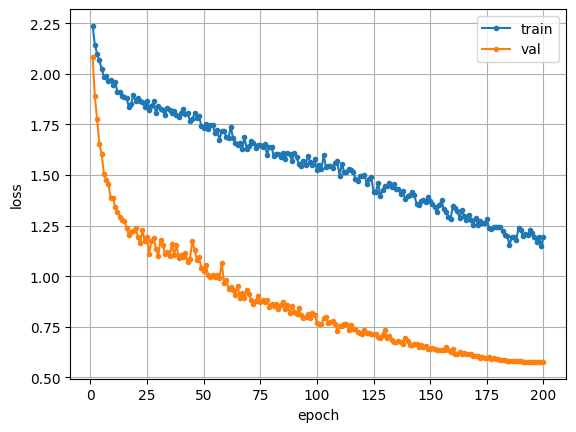

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['train loss']) + 1)
ax.plot(xs, history['train loss'], '.-', label='train')
ax.plot(xs, history['val loss'], '.-', label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
ax.grid()
plt.show()

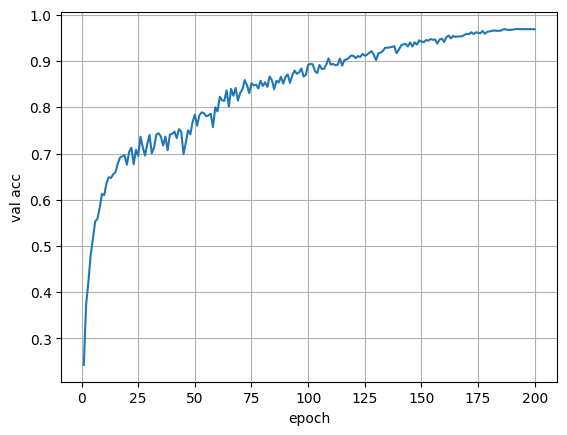

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['val acc']) + 1)
ax.plot(xs, history['val acc'], '-')
ax.set_xlabel('epoch')
ax.set_ylabel('val acc')
ax.grid()
plt.show()